# Rare event probability estimation

This example introduces a few event probability estimation methods implemented in OpenTURNS.

In [1]:
import openturns as ot
from openturns.viewer import View
%pylab --no-import-all inline

Populating the interactive namespace from numpy and matplotlib


# Problem definition

# Input probabilistic model

In [2]:
sample_E = ot.NumericalSample.ImportFromCSVFile("sample_E.csv") 
kernel_smoothing = ot.KernelSmoothing(ot.Normal())
bandwidth = kernel_smoothing.computeSilvermanBandwidth(sample_E)
E = kernel_smoothing.build(sample_E, bandwidth)
E.setDescription(['Young modulus'])

In [3]:
F = ot.LogNormal()
F.setParameter(ot.LogNormalMuSigma()([30000, 9000, 15000]))
F.setDescription(['Load'])

In [4]:
L = ot.Uniform(250, 260)
L.setDescription(['Length'])

In [5]:
I = ot.Beta(2.5, 4, 310, 450)
I.setDescription(['Inertia'])

We now fix the order of the marginal distributions in the joint distribution. Order must match in the implementation of the physical model (to come).

In [6]:
marginal_distributions = [F, E, L, I]

Let then define the dependence structure as a Normal copula with a single non-zero Spearman correlation between components 2 and 3 of the final random vector, that is $L$ and $I$.

In [7]:
SR_cor = ot.CorrelationMatrix(len(marginal_distributions))
SR_cor[2, 3] = -0.2
copula = ot.NormalCopula(ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(SR_cor))

Eventually the input joint distribution is defined as a *composed distribution*.

In [8]:
X_distribution = ot.ComposedDistribution(marginal_distributions, copula)

... And let's make a *random vector* out of this distribution.

In [9]:
X_random_vector = ot.RandomVector(X_distribution)

## Limit-state function

In [10]:
g = ot.Function(['F', 'E', 'L', 'I'], ['v'], ['F*L^3/(3*E*I)'])

In [11]:
g.enableCache()

In [12]:
g.enableHistory()

In [13]:
print 'Class : ', g.getClassName()
print 'Input : ', g.getDescription()
print 'Ouput : ', g.getOutputDescription()
print 'Evaluation : ', g.getEvaluation()
print 'Gradient : ', g.getGradient()
print 'Hessian : ', g.getHessian()

Class :  Function
Input :  [F,E,L,I,v]
Ouput :  [v]
Evaluation :  [F,E,L,I]->[F*L^3/(3*E*I)]
Gradient :  
| d(v) / d(F) = (0.333333*((L^3)/((E)*(I))))
| d(v) / d(E) = (-0.333333*(((F)*(L^3)*(I))/(((E)*(I))^(2))))
| d(v) / d(L) = ((F)*(L^2))/((E)*(I))
| d(v) / d(I) = (-0.333333*(((F)*(L^3)*(E))/(((E)*(I))^(2))))

Hessian :  
|   d^2(v) / d(F)^2 = 0
| d^2(v) / d(E)d(F) = (-0.333333*(((I)*(L^3))/(((E)*(I))^(2))))
|   d^2(v) / d(E)^2 = (0.333333*(((2*((F)*(L^3)*(I^3)*(E))))/((((E)*(I))^(2))^(2))))
| d^2(v) / d(L)d(F) = (L^2)/((E)*(I))
| d^2(v) / d(L)d(E) = (-(((F)*(L^2)*(I))/(((E)*(I))^(2))))
|   d^2(v) / d(L)^2 = (2*(((F)*(L))/((E)*(I))))
| d^2(v) / d(I)d(F) = (-0.333333*(((E)*(L^3))/(((E)*(I))^(2))))
| d^2(v) / d(I)d(E) = ((-0.333333*(((F)*(L^3))/(((E)*(I))^(2)))))+((0.333333*(((2*((F)*(L^3)*(E^2)*(I^2))))/((((E)*(I))^(2))^(2)))))
| d^2(v) / d(I)d(L) = (-(((F)*(E)*(L^2))/(((E)*(I))^(2))))
|   d^2(v) / d(I)^2 = (0.333333*(((2*((F)*(L^3)*(E^3)*(I))))/((((E)*(I))^(2))^(2))))



In [14]:
input_point = [321., 3e9, 2.5, 4e-6]
print 'Value of the function at input_point: %s' % g(input_point)
print 'Value of the gradient at input_point: %s' % g.gradient(input_point)
print 'Value of the hessian at input_point: %s' % g.hessian(input_point)

Value of the function at input_point: [0.139323]
Value of the gradient at input_point: [[      0.000434027 ]
 [     -4.64409e-11 ]
 [      0.167187    ]
 [ -34830.7         ]]
Value of the hessian at input_point: sheet #0
[[      0               -1.44676e-13      0.000520833   -108.507       ]
 [     -1.44676e-13      3.09606e-20     -5.57292e-11      1.16102e-05 ]
 [      0.000520833     -5.57292e-11      0.13375     -41796.9         ]
 [   -108.507            1.16102e-05 -41796.9              1.74153e+10 ]]


# Output random vector

In [15]:
G = ot.RandomVector(g, X_random_vector)
G.setDescription(['Deviation'])

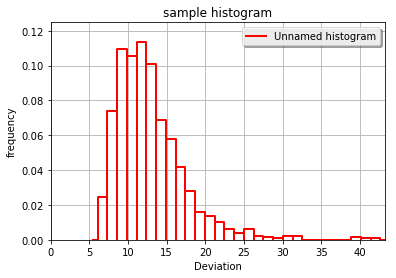

In [16]:
G_sample = G.getSample(int(1e3))
G_hist = ot.VisualTest_DrawHistogram(G_sample)
G_hist.setXTitle(G.getDescription()[0])
_ = View(G_hist, bar_kwargs={'label':'G_sample'})

# Event

In [17]:
event = ot.Event(G, ot.GreaterOrEqual(), 30.)
event.setName("deviation > 30 cm")

# Estimation of the event probability using (crude) Monte Carlo sampling

In [18]:
g.clearHistory()

In [19]:
ot.RandomGenerator.SetSeed(0)

In [20]:
MCS_algorithm = ot.MonteCarlo(event)
MCS_algorithm.setMaximumCoefficientOfVariation(.1)
MCS_algorithm.setMaximumOuterSampling(40000)
MCS_algorithm.setBlockSize(100)
MCS_algorithm.run()
MCS_results = MCS_algorithm.getResult()
MCS_evaluation_number = g.getHistoryInput().getSample().getSize()

In [21]:
print 'Probability estimate: %.3e' % MCS_results.getProbabilityEstimate()
print 'Coefficient of variation: %.2f' % MCS_results.getCoefficientOfVariation()
print 'Number of evaluations: %d' % MCS_evaluation_number

Probability estimate: 6.558e-03
Coefficient of variation: 0.10
Number of evaluations: 15400


/gpfslocal/pub/python/anaconda/Anaconda2-4.3.1/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


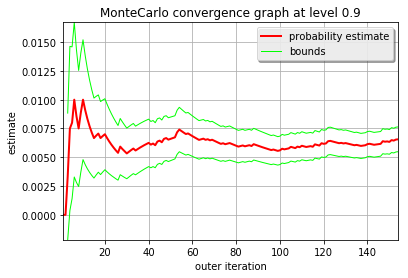

In [22]:
confidence_level = .9
MCS_convergence_graph = MCS_algorithm.drawProbabilityConvergence(confidence_level)
_ = View(MCS_convergence_graph).show()

# *Most-probable-failure-point*-based approaches

## Search for the *most point failure point* (MPFP)

In [24]:
mpfp_search_algorithm = ot.AbdoRackwitz() # Alternatives: ot.AbdoRackwitz(), ot.Cobyla()
mpfp_search_algorithm.setMaximumIterationNumber(int(1e3))
mpfp_search_algorithm.setMaximumAbsoluteError(1e-10)
mpfp_search_algorithm.setMaximumRelativeError(1e-10)
mpfp_search_algorithm.setMaximumResidualError(1e-10)
mpfp_search_algorithm.setMaximumConstraintError(1e-10)
print(mpfp_search_algorithm)

class=AbdoRackwitz class=OptimizationAlgorithmImplementation problem=class=OptimizationProblem implementation=class=OptimizationProblemImplementation objective=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[] evaluationImplementation=class=NoEvaluation name=Unnamed gradientImplementation=class=NoGradient name=Unnamed hessianImplementation=class=NoHessian name=Unnamed equality constraint=none inequality constraint=none bounds=none minimization=true dimension=0 startingPoint=class=Point name=Unnamed dimension=0 values=[] maximumIterationNumber=1000 maximumEvaluationNumber=100000 maximumAbsoluteError=1e-10 maximumRelativeError=1e-10 maximumResidualError=1e-10 maximumConstraintError=1e-10 verbose=false tau=0.5 omega=0.0001 smooth=1.2


## *First-order-reliability-method* (FORM)

In [25]:
g.clearHistory()

In [26]:
FORM_algorithm = ot.FORM(mpfp_search_algorithm,
                         event,
                         X_distribution.getMean())
FORM_algorithm.run()
FORM_result = FORM_algorithm.getResult()

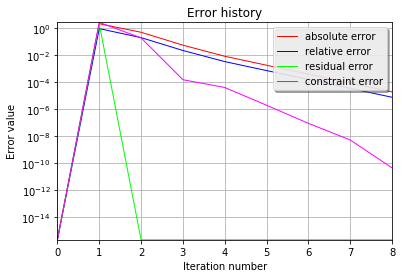

In [27]:
mpfp_search_result = FORM_result.getOptimizationResult()
_ = View(mpfp_search_result.drawErrorHistory())

In [28]:
print "Standard space design point: %s" % FORM_result.getStandardSpaceDesignPoint()
print "Physical space design point: %s" % FORM_result.getPhysicalSpaceDesignPoint()
print "Hasofer-Lind reliability index: %.2f" % FORM_result.getHasoferReliabilityIndex()
print "First-order approximation of the event probability: %.3e" % FORM_result.getEventProbability()
print "Number of evaluations of the limit-state function: %s" % g.getHistoryInput().getSample().getSize()

Standard space design point: [2.30373,-0.655182,0.355125,-0.532558]
Physical space design point: [61143.5,3.02361e+07,256.388,378.681]
Hasofer-Lind reliability index: 2.48
First-order approximation of the event probability: 6.585e-03
Number of evaluations of the limit-state function: 11


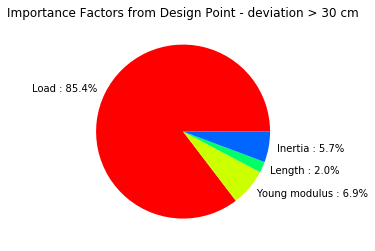

In [29]:
_ = View(FORM_result.drawImportanceFactors())

## *Second-order reliability method* (SORM)

In [30]:
g.clearHistory()

In [31]:
SORM_algo = ot.SORM(mpfp_search_algorithm, event, FORM_result.getPhysicalSpaceDesignPoint())
SORM_algo.run()
SORM_result = SORM_algo.getResult()

In [32]:
print "Breitung reliability index: %.2f" % SORM_result.getGeneralisedReliabilityIndexBreitung()
print "Breitung second-order approximation of the probability: %.3e" % SORM_result.getEventProbabilityBreitung()
print "Number of evaluations of the limit-state function: %s" % g.getHistoryInput().getSample().getSize()

Breitung reliability index: 2.52
Breitung second-order approximation of the probability: 5.881e-03
Number of evaluations of the limit-state function: 5


# *Most-probable-failure-point*-based importance sampling

In [33]:
g.clearHistory()

In [34]:
instrumental_distribution = ot.Normal(FORM_result.getStandardSpaceDesignPoint(),
                                      ot.CovarianceMatrix(X_distribution.getDimension()))
IS_algorithm = ot.ImportanceSampling(ot.StandardEvent(event),
                                     instrumental_distribution)
IS_algorithm.setMaximumOuterSampling(40000)
IS_algorithm.setBlockSize(1)
IS_algorithm.setMaximumCoefficientOfVariation(.1)
IS_algorithm.run()
IS_result = IS_algorithm.getResult()

In [35]:
print "Probability estimate: %.3e" % IS_result.getProbabilityEstimate()
print "Coefficient of variation: %.2f" % IS_result.getCoefficientOfVariation()
print "Number of evaluations: %d" % g.getHistoryInput().getSample().getSize()

Probability estimate: 5.864e-03
Coefficient of variation: 0.10
Number of evaluations: 292


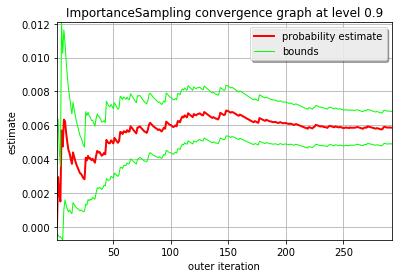

In [36]:
confidence_level = 0.9
IS_convergence_graph = IS_algorithm.drawProbabilityConvergence(confidence_level)
_ = View(IS_convergence_graph)

# Directional sampling

In [37]:
g.clearHistory()

In [38]:
root_strategy = ot.RiskyAndFast() # Alternatives : ot.SafeAndSlow(), ot.MediumSafe(), ot.RiskyAndFast()
root_strategy.setSolver(ot.Brent()) # Alternatives : ot.Bisection(), ot.Secant(), ot.Brent()

In [39]:
sampling_strategy = ot.RandomDirection() # Alternatives : ot.RandomDirection(), ot.OrthogonalDirection()
sampling_strategy.setDimension(X_distribution.getDimension())

In [40]:
ot.RandomGenerator.SetSeed(0)

In [41]:
DS_algorithm = ot.DirectionalSampling(event)
DS_algorithm.setMaximumCoefficientOfVariation(.1)
DS_algorithm.setMaximumOuterSampling(10000)
DS_algorithm.setBlockSize(1)
DS_algorithm.setRootStrategy(root_strategy)
DS_algorithm.setSamplingStrategy(sampling_strategy)
DS_algorithm.run()
DS_result = DS_algorithm.getResult()

In [42]:
print "Probability estimate:     %.3e" % DS_result.getProbabilityEstimate()
print "Coefficient of variation: %.2f" % DS_result.getCoefficientOfVariation()
print "Number of evaluations:    %d" % g.getHistoryInput().getSample().getSize()

Probability estimate:     6.370e-03
Coefficient of variation: 0.10
Number of evaluations:    3906


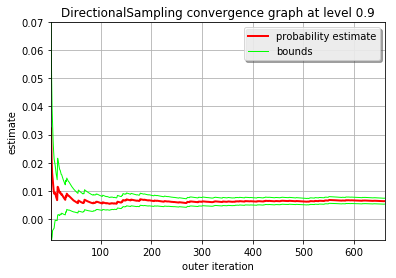

In [43]:
confidence_level = .9
DS_convergence_graph = DS_algorithm.drawProbabilityConvergence(confidence_level)
_ = View(DS_convergence_graph).show()